# Task 6 and 7 


In [2]:
!pip install scikit-image skan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 12.6 MB/s eta 0:00:0000:0100:01


Detected 76 root systems


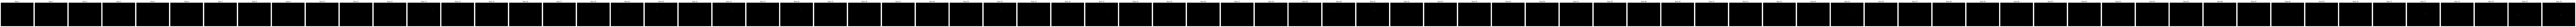

/var/folders/kz/slhyr0gd4qj4nrryyswvqv4c0000gn/T/ipykernel_27488/2536307152.py:47: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


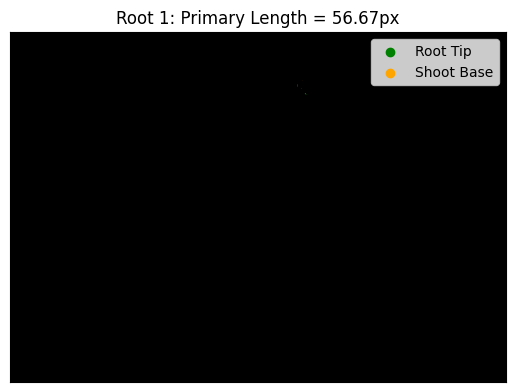

/var/folders/kz/slhyr0gd4qj4nrryyswvqv4c0000gn/T/ipykernel_27488/2536307152.py:47: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


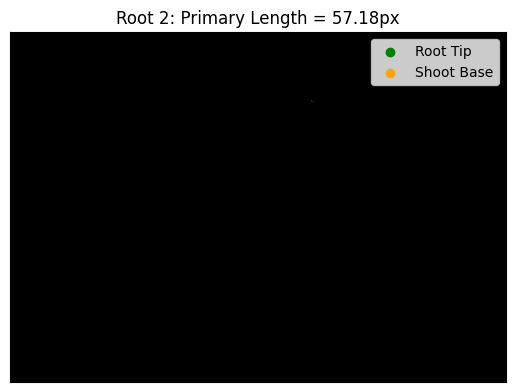

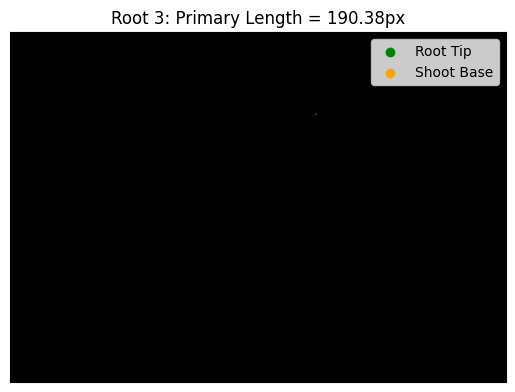

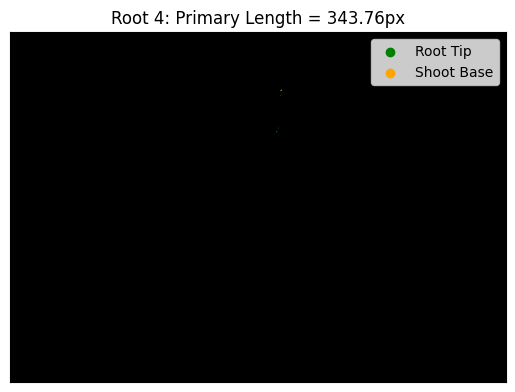

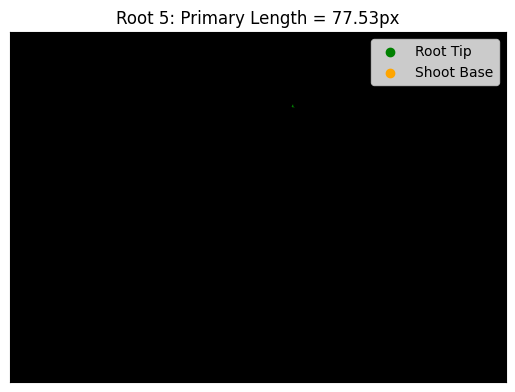

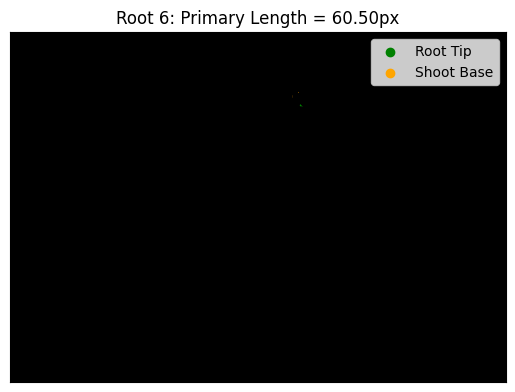

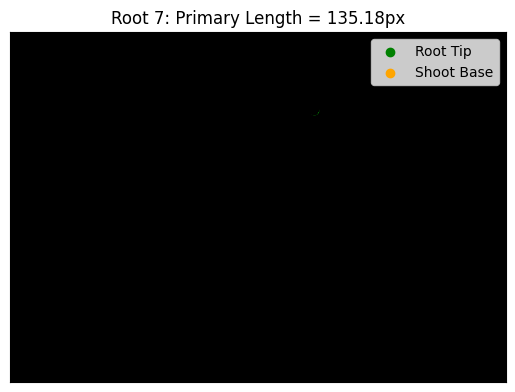

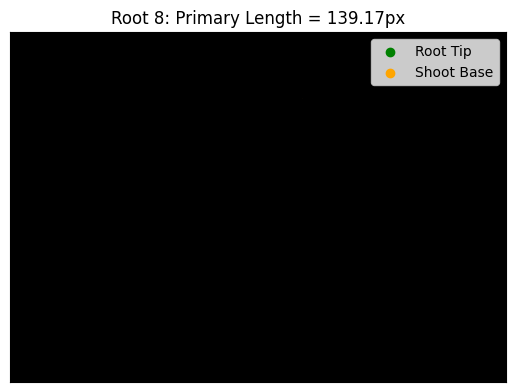

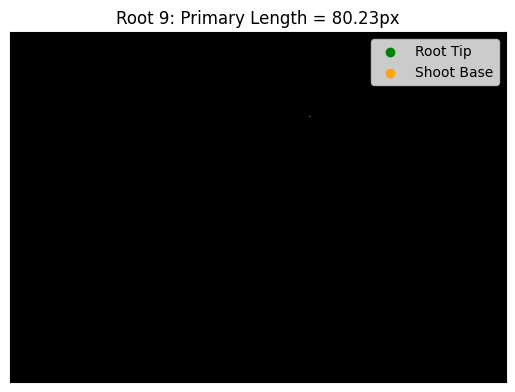

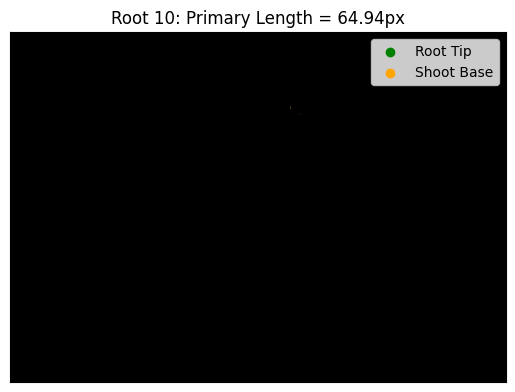

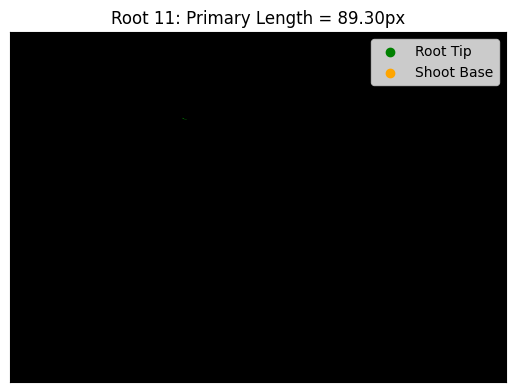

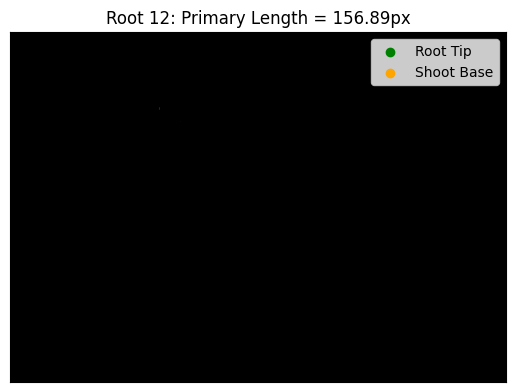

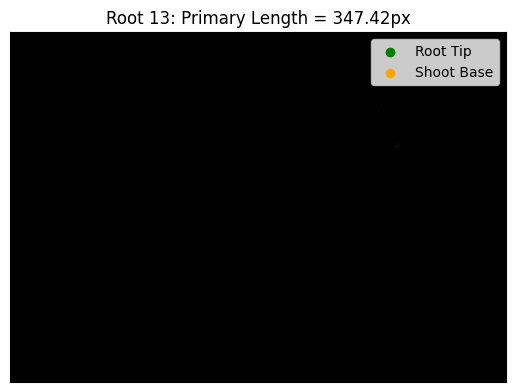

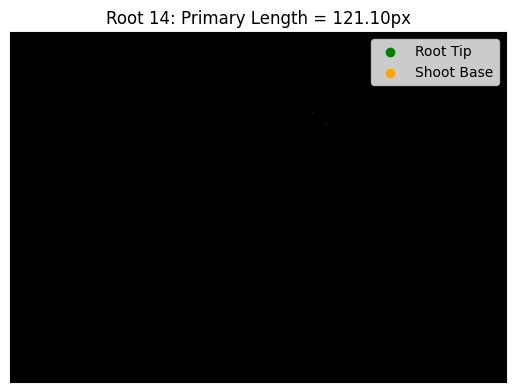

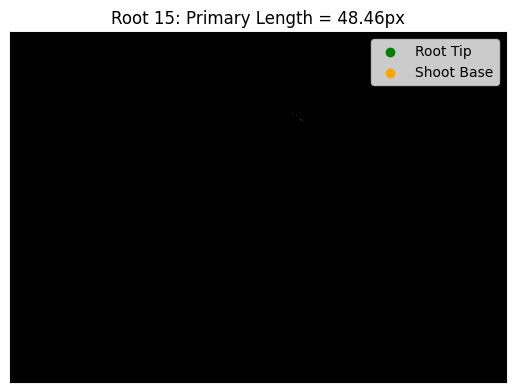

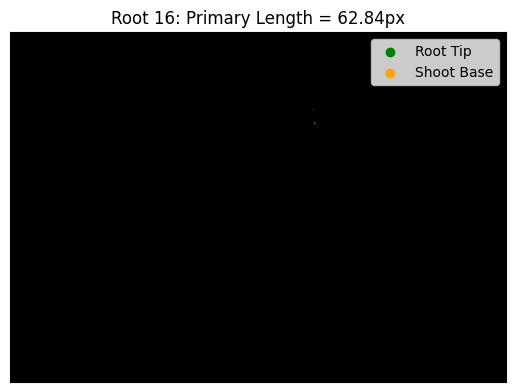

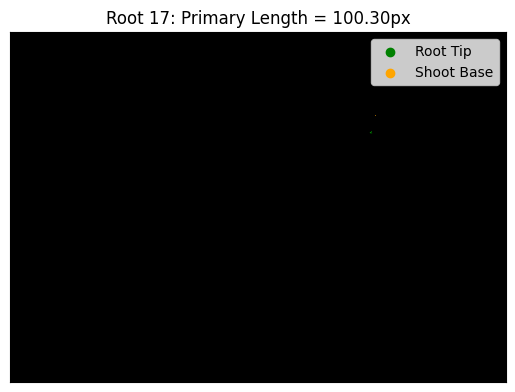

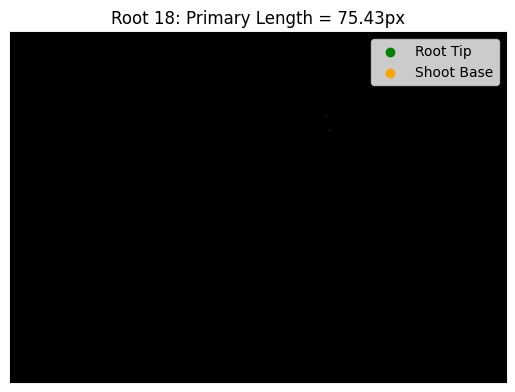

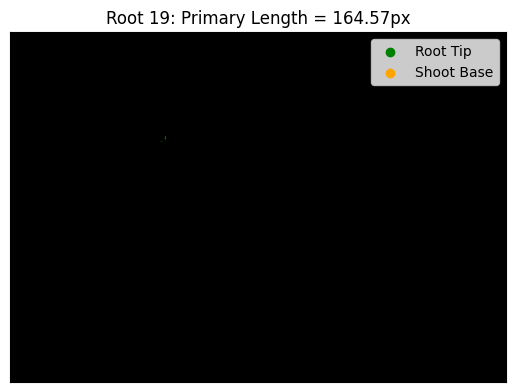

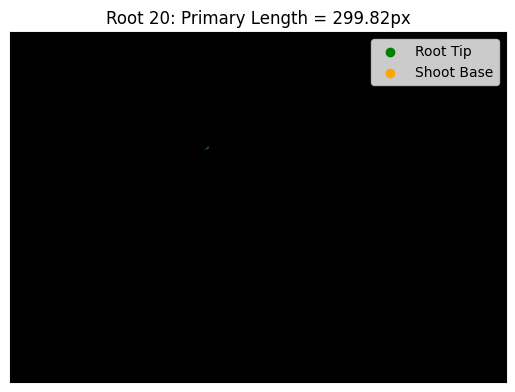

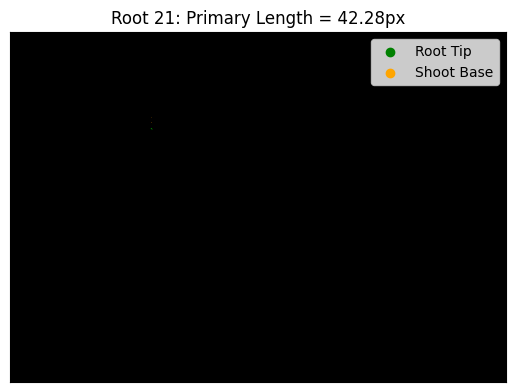

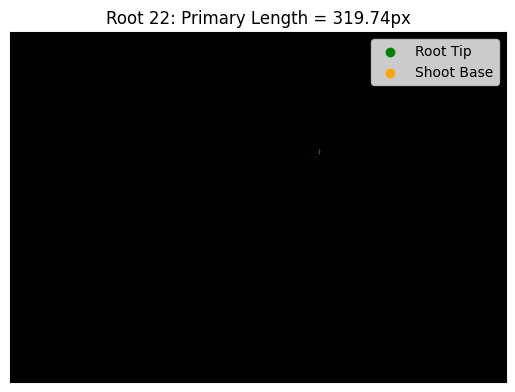

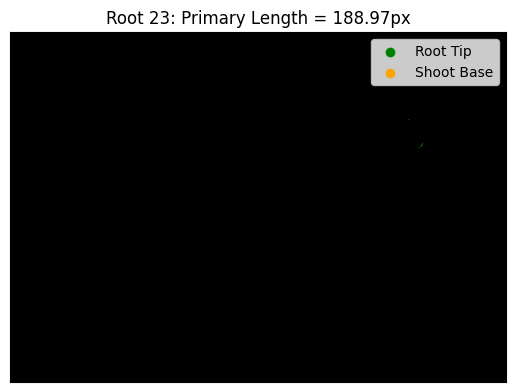

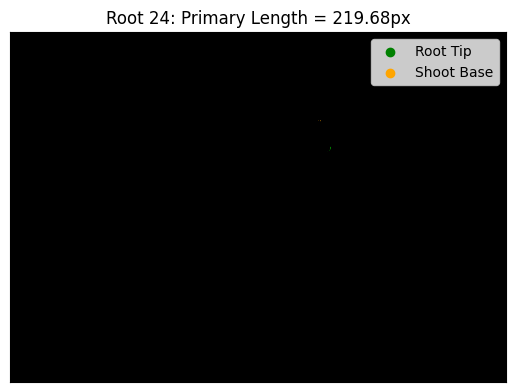

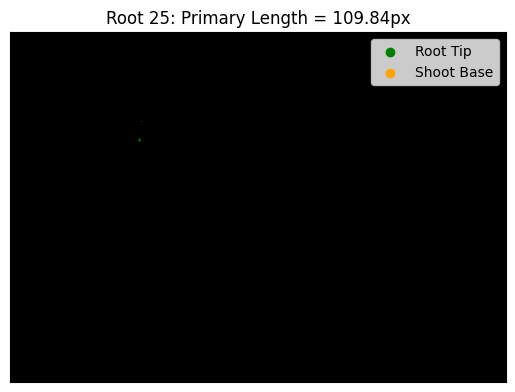

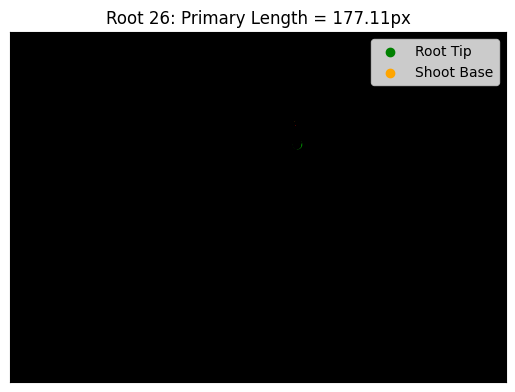

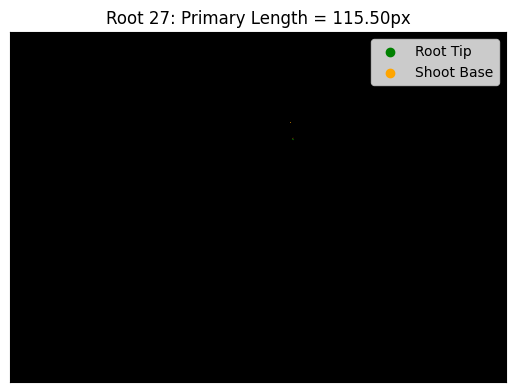

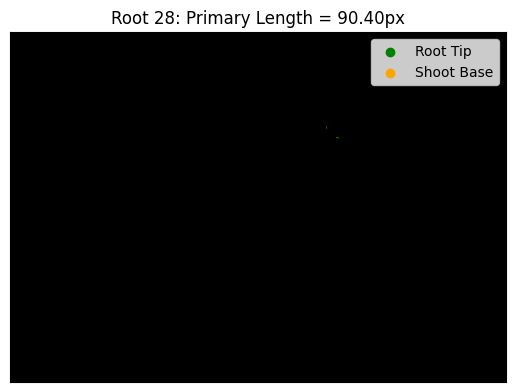

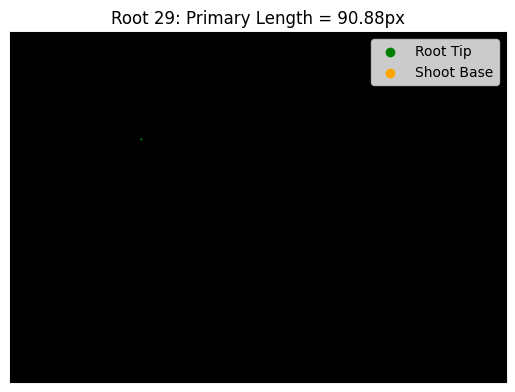

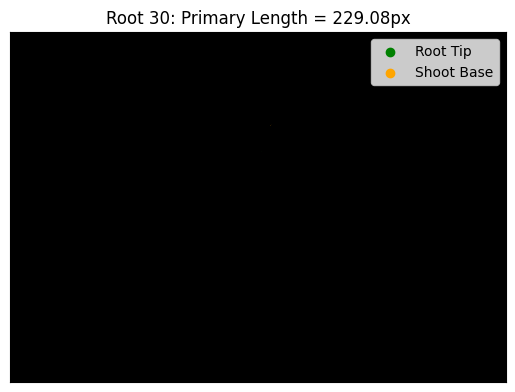

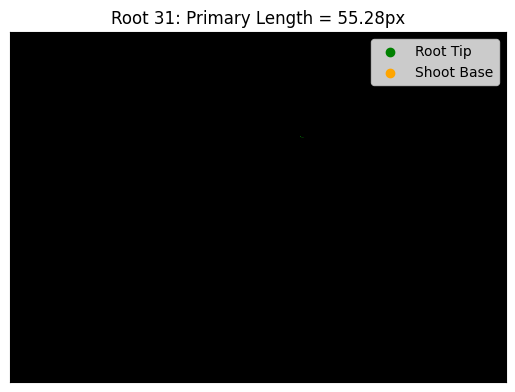

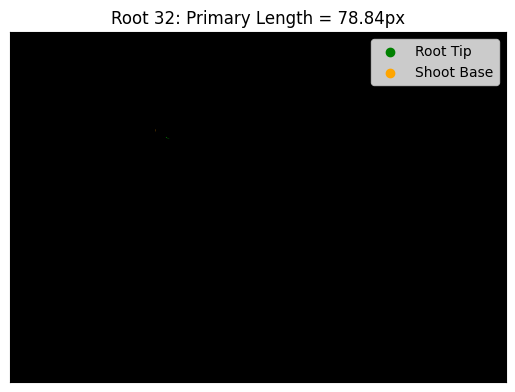

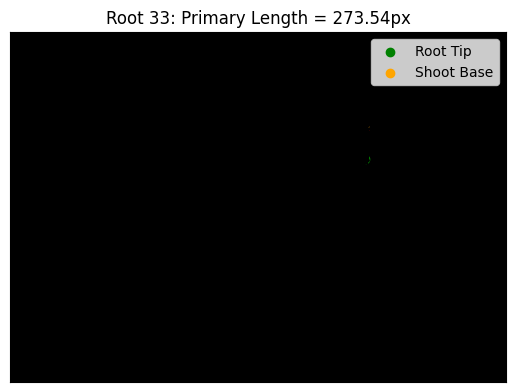

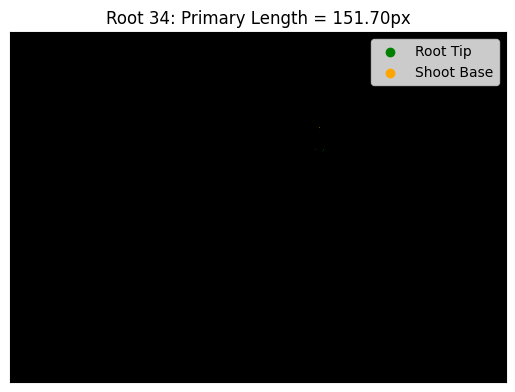

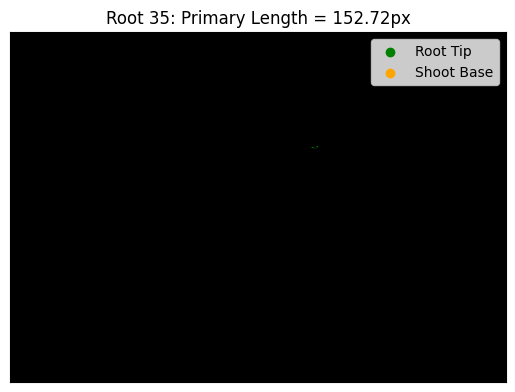

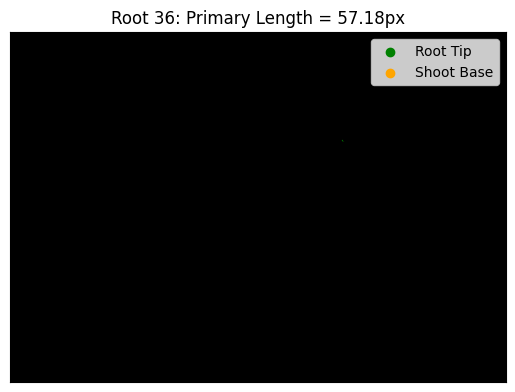

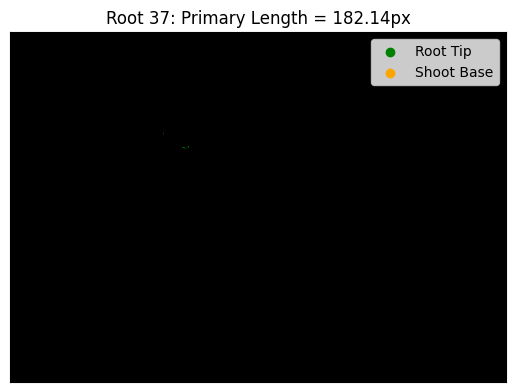

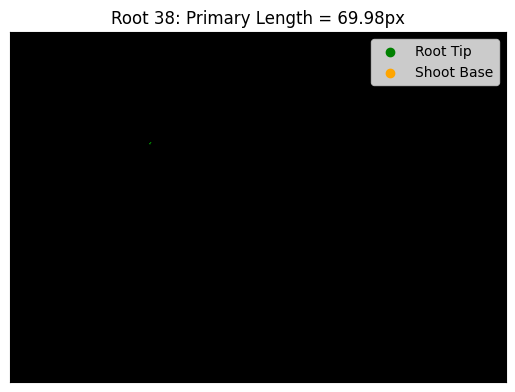

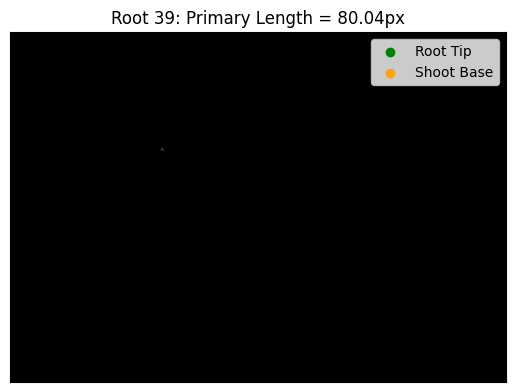

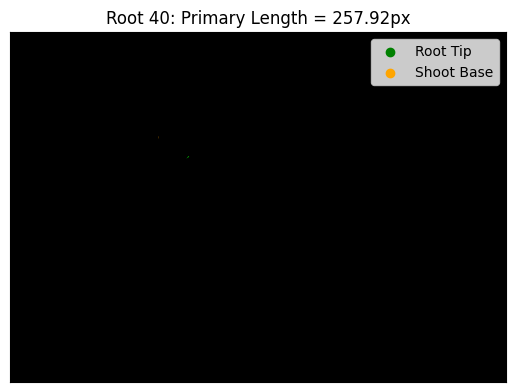

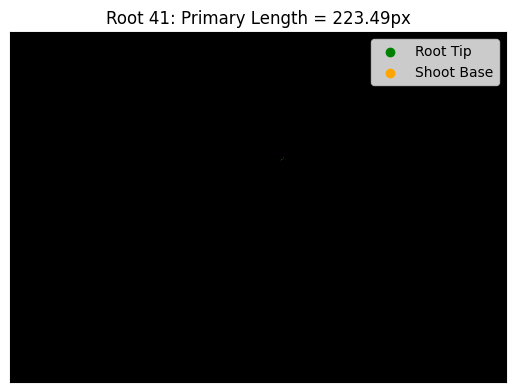

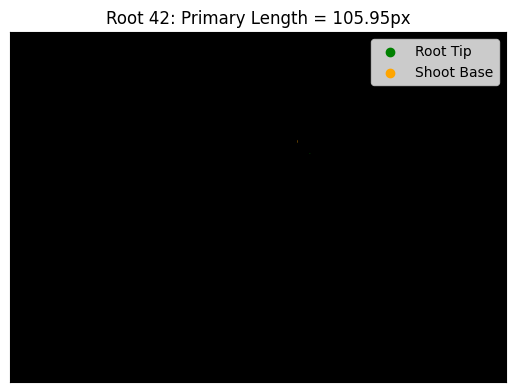

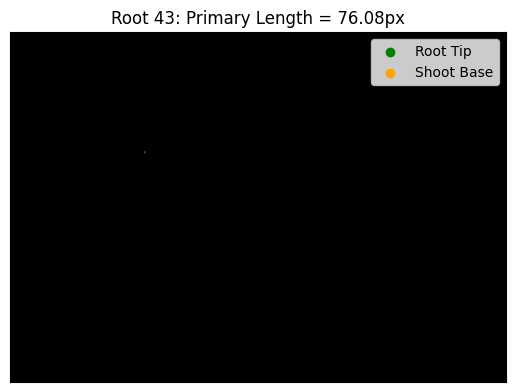

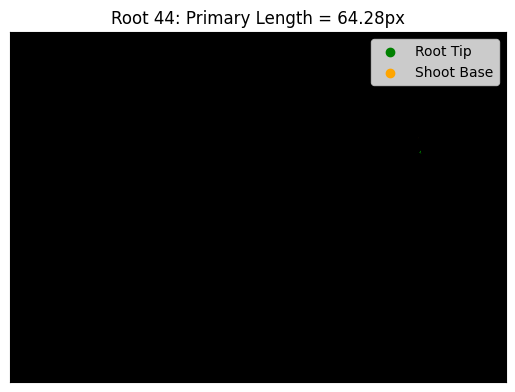

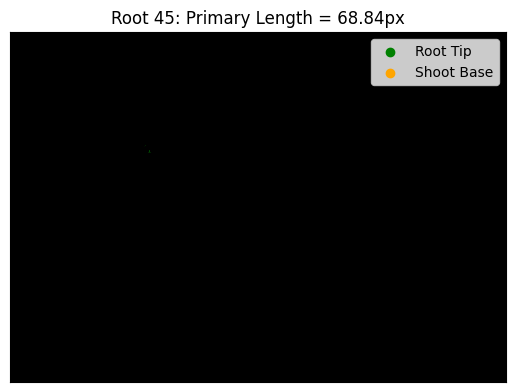

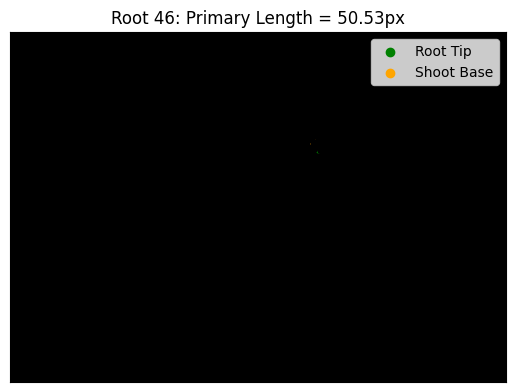

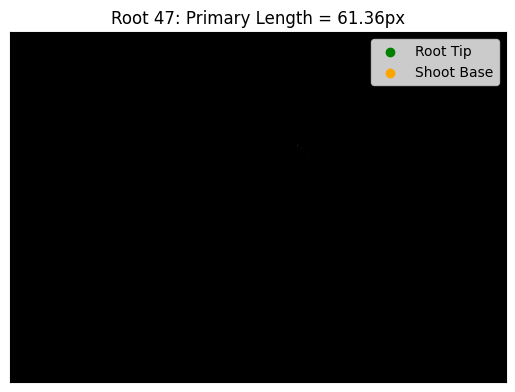

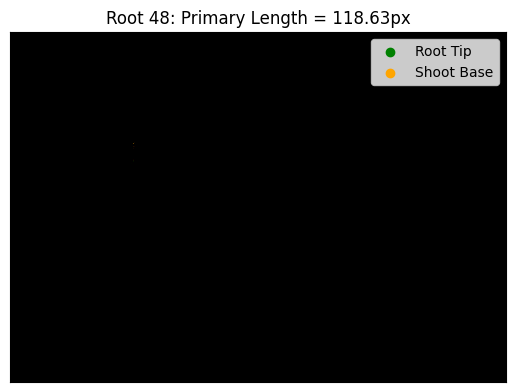

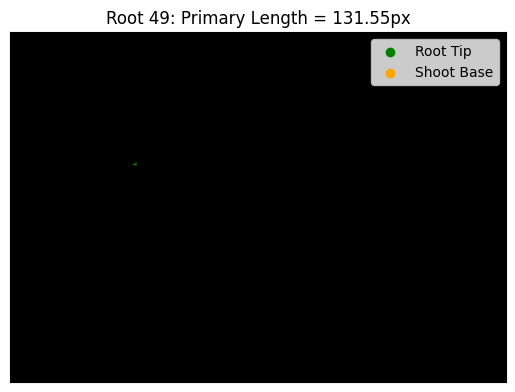

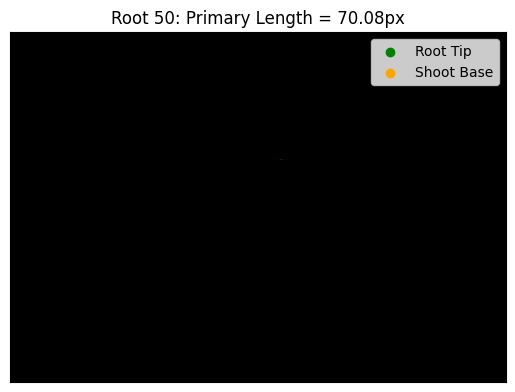

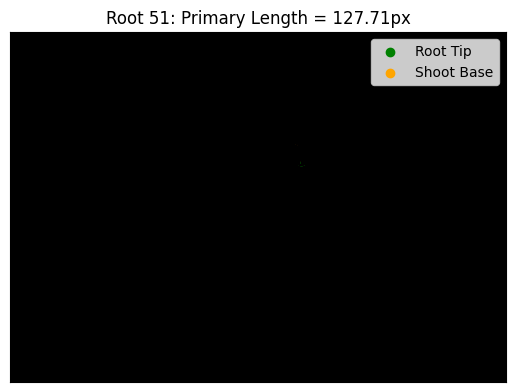

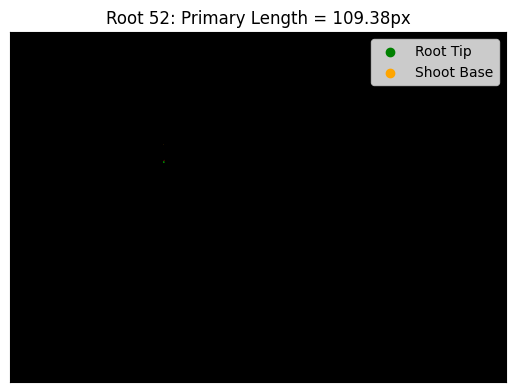

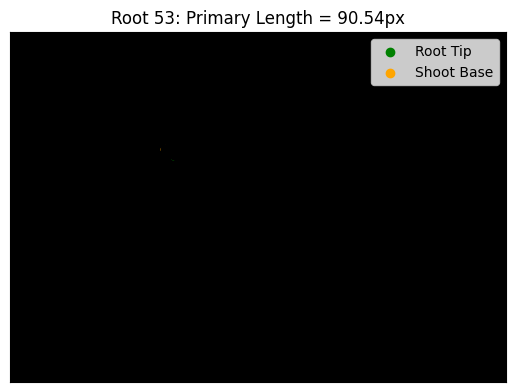

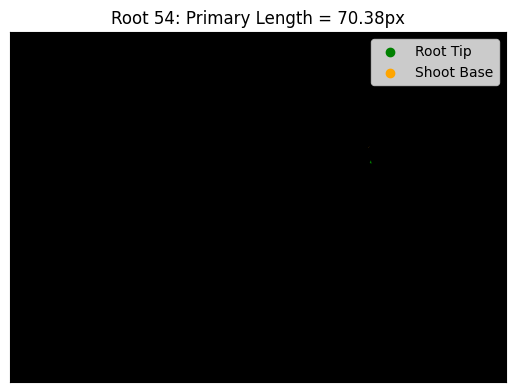

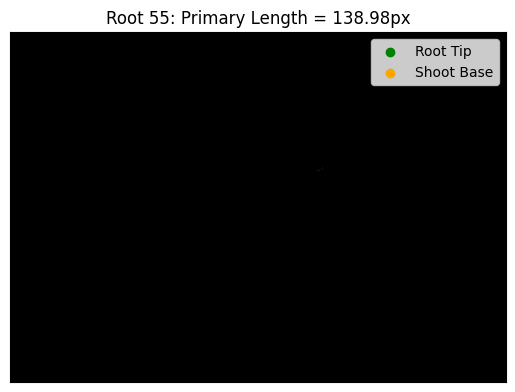

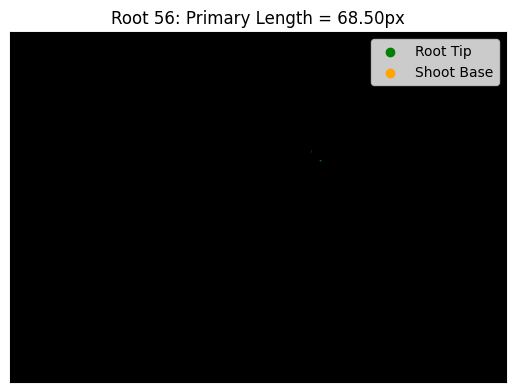

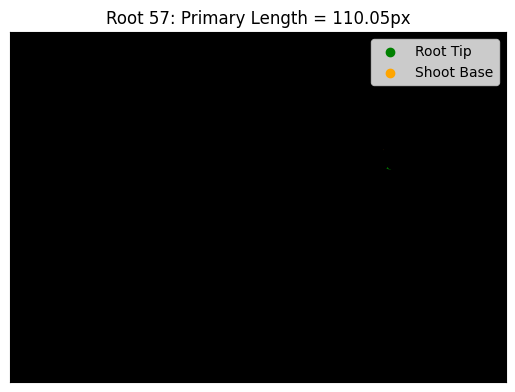

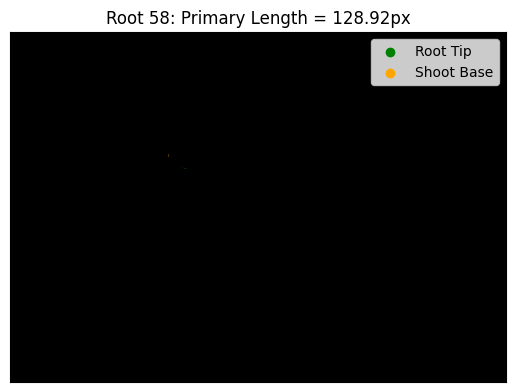

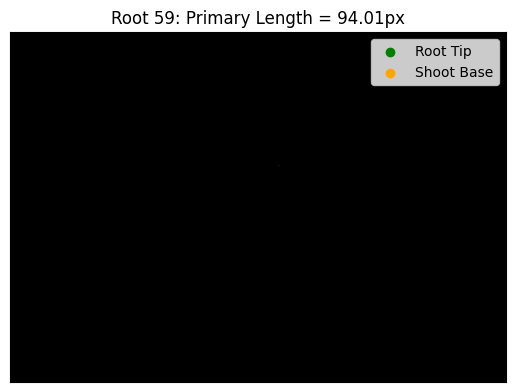

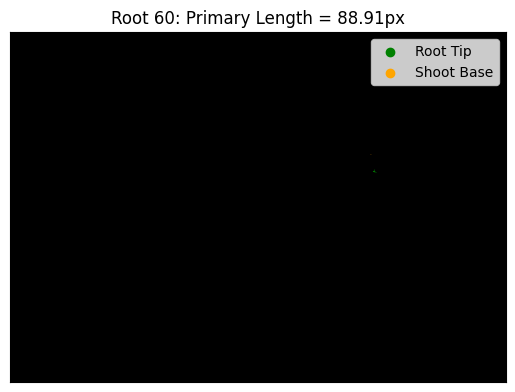

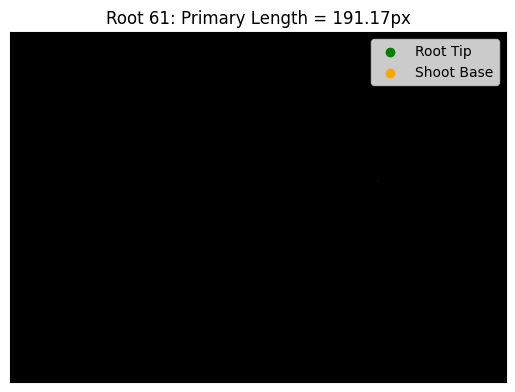

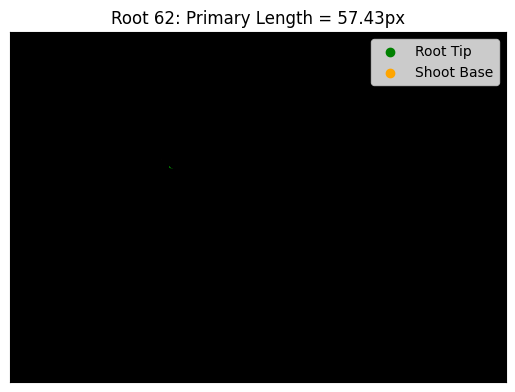

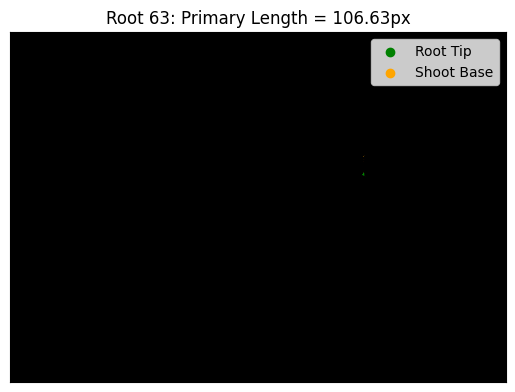

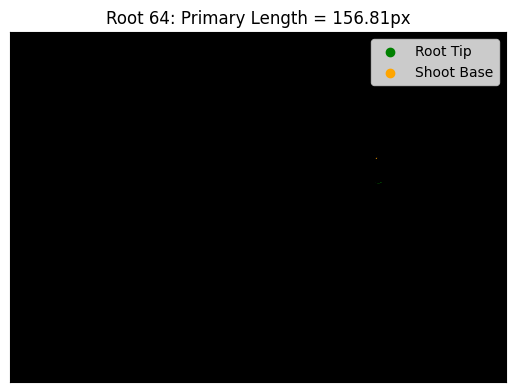

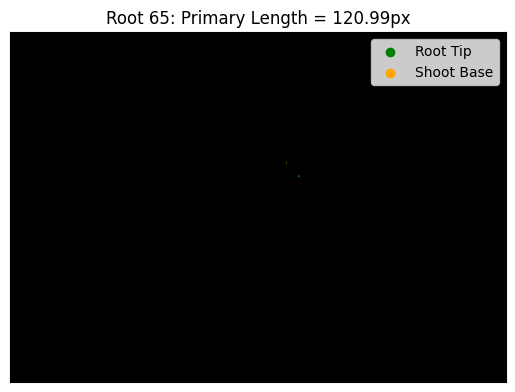

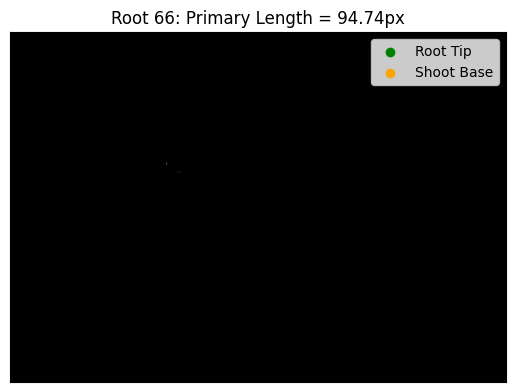

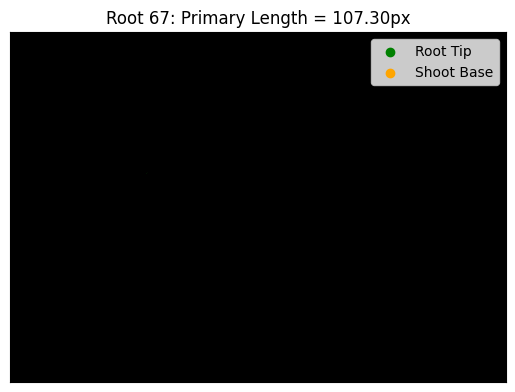

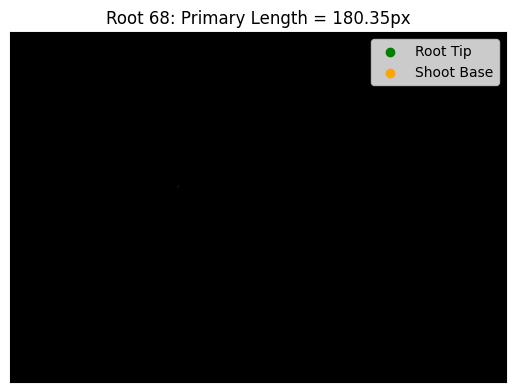

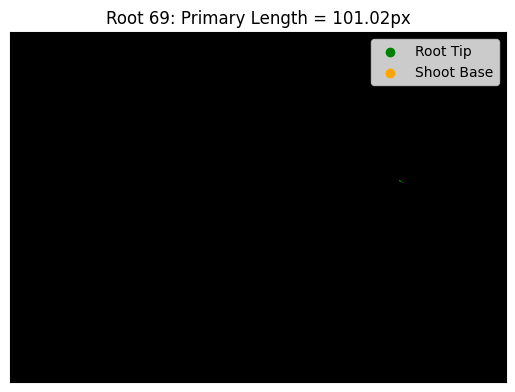

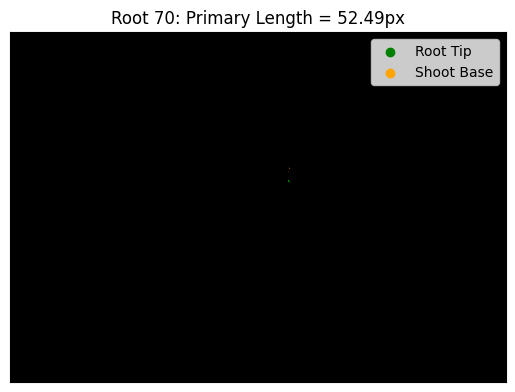

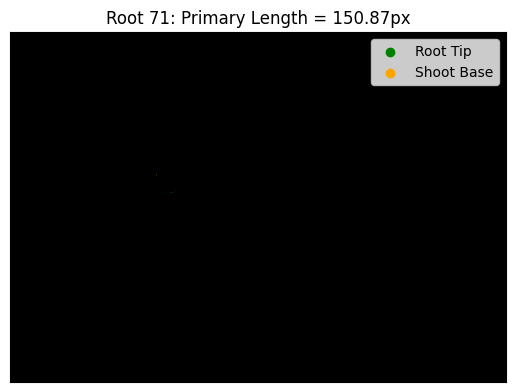

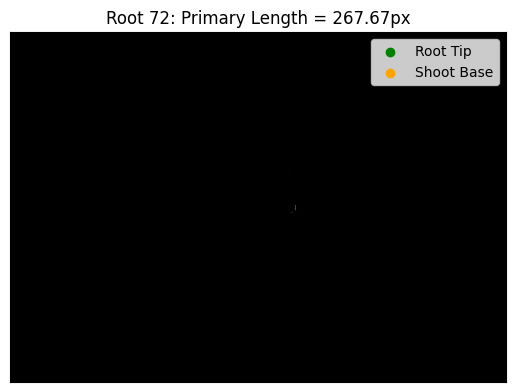

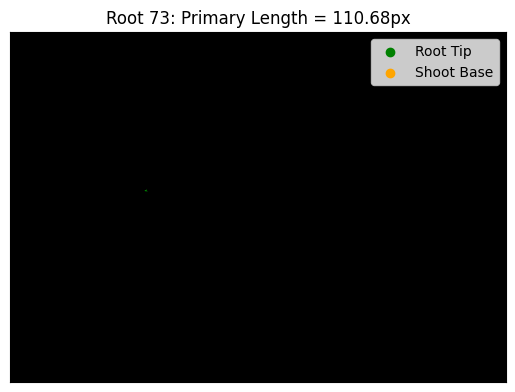

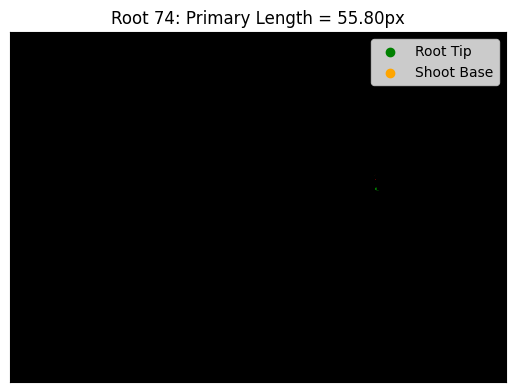

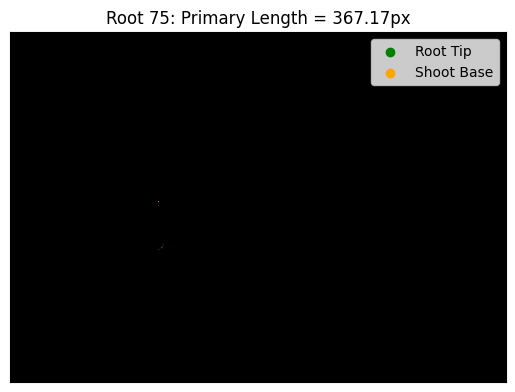

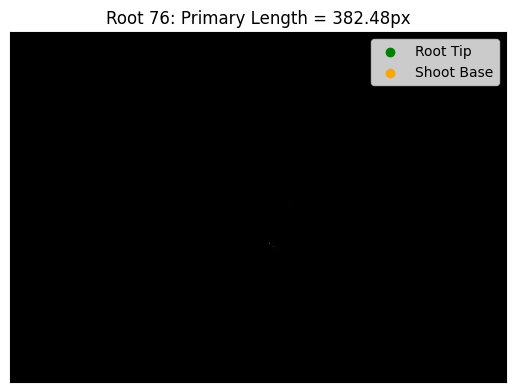


Primary Root Lengths:
Root 1: 56.67 px
Root 2: 57.18 px
Root 3: 190.38 px
Root 4: 343.76 px
Root 5: 77.53 px
Root 6: 60.50 px
Root 7: 135.18 px
Root 8: 139.17 px
Root 9: 80.23 px
Root 10: 64.94 px
Root 11: 89.30 px
Root 12: 156.89 px
Root 13: 347.42 px
Root 14: 121.10 px
Root 15: 48.46 px
Root 16: 62.84 px
Root 17: 100.30 px
Root 18: 75.43 px
Root 19: 164.57 px
Root 20: 299.82 px
Root 21: 42.28 px
Root 22: 319.74 px
Root 23: 188.97 px
Root 24: 219.68 px
Root 25: 109.84 px
Root 26: 177.11 px
Root 27: 115.50 px
Root 28: 90.40 px
Root 29: 90.88 px
Root 30: 229.08 px
Root 31: 55.28 px
Root 32: 78.84 px
Root 33: 273.54 px
Root 34: 151.70 px
Root 35: 152.72 px
Root 36: 57.18 px
Root 37: 182.14 px
Root 38: 69.98 px
Root 39: 80.04 px
Root 40: 257.92 px
Root 41: 223.49 px
Root 42: 105.95 px
Root 43: 76.08 px
Root 44: 64.28 px
Root 45: 68.84 px
Root 46: 50.53 px
Root 47: 61.36 px
Root 48: 118.63 px
Root 49: 131.55 px
Root 50: 70.08 px
Root 51: 127.71 px
Root 52: 109.38 px
Root 53: 90.54 px
Root

In [3]:
# Task 6 & 7: Individual Root Segmentation & RSA Extraction

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, skeletonize
from skimage.measure import label, regionprops
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx
import os

# --- Paths ---
image_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image.png"
pred_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image_prediction_celine_231265.png"

# --- Load Image and Prediction Mask ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

# --- Threshold & Clean Mask ---
_, binary_mask = cv2.threshold(pred_mask, 30, 255, cv2.THRESH_BINARY)
cleaned_mask = remove_small_objects(binary_mask > 0, min_size=200)

# --- Label Individual Roots ---
labeled_mask = label(cleaned_mask)
num_roots = labeled_mask.max()
print(f"Detected {num_roots} root systems")

# --- Plot Individual Root Masks ---
fig, axes = plt.subplots(1, num_roots, figsize=(4*num_roots, 4))
if num_roots == 1:
    axes = [axes]
for i in range(1, num_roots+1):
    mask = labeled_mask == i
    axes[i-1].imshow(mask, cmap='gray')
    axes[i-1].set_title(f"Root {i}")
    axes[i-1].axis('off')
plt.tight_layout()
plt.show()

# --- Task 7: RSA Extraction ---
def analyze_root(mask, root_id):
    skel = skeletonize(mask)
    g0, c0 = skeleton_to_csgraph(skel)
    skeleton_obj = Skeleton(skel)
    branch_data = summarize(skeleton_obj)
    G = nx.from_pandas_edgelist(branch_data, 'node-id-src', 'node-id-dst', edge_attr='branch-distance')
    coords = np.transpose(c0)

    degree_1_nodes = [n for n in G.nodes if G.degree[n] == 1]
    if len(degree_1_nodes) < 2:
        print(f"Root {root_id}: Not enough endpoints found.")
        return None

    lowest = max(degree_1_nodes, key=lambda n: coords[n][0])
    highest = min(degree_1_nodes, key=lambda n: coords[n][0])

    try:
        path = nx.shortest_path(G, lowest, highest, weight='branch-distance')
        dist = nx.shortest_path_length(G, lowest, highest, weight='branch-distance')
    except nx.NetworkXNoPath:
        print(f"Root {root_id}: No path found.")
        return None

    # --- Visualization ---
    fig, ax = plt.subplots()
    draw.overlay_skeleton_networkx(g0, coords, image=skel, axis=ax, node_size=0)
    ax.scatter(*coords[lowest][::-1], c='green', label='Root Tip')
    ax.scatter(*coords[highest][::-1], c='orange', label='Shoot Base')
    for i in range(len(path)-1):
        y1, x1 = coords[path[i]]
        y2, x2 = coords[path[i+1]]
        ax.plot([x1, x2], [y1, y2], color='red', lw=1.5)
    ax.set_title(f"Root {root_id}: Primary Length = {dist:.2f}px")
    ax.legend()
    plt.show()
    return dist

# --- Analyze Each Root ---
lengths = []
for i in range(1, num_roots+1):
    mask = labeled_mask == i
    length = analyze_root(mask, i)
    if length:
        lengths.append((i, length))

# --- Print Results ---
print("\nPrimary Root Lengths:")
for root_id, length in lengths:
    print(f"Root {root_id}: {length:.2f} px")

Detected 4 root systems


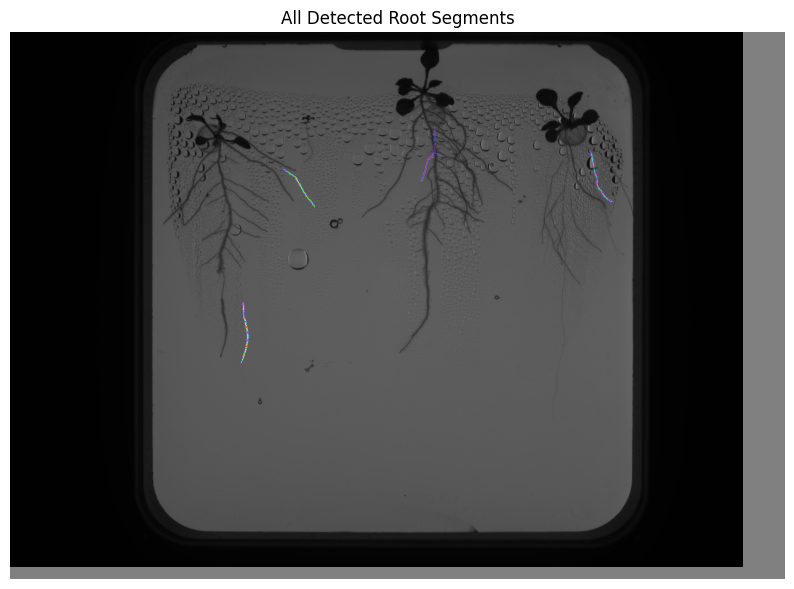

IndexError: list index out of range

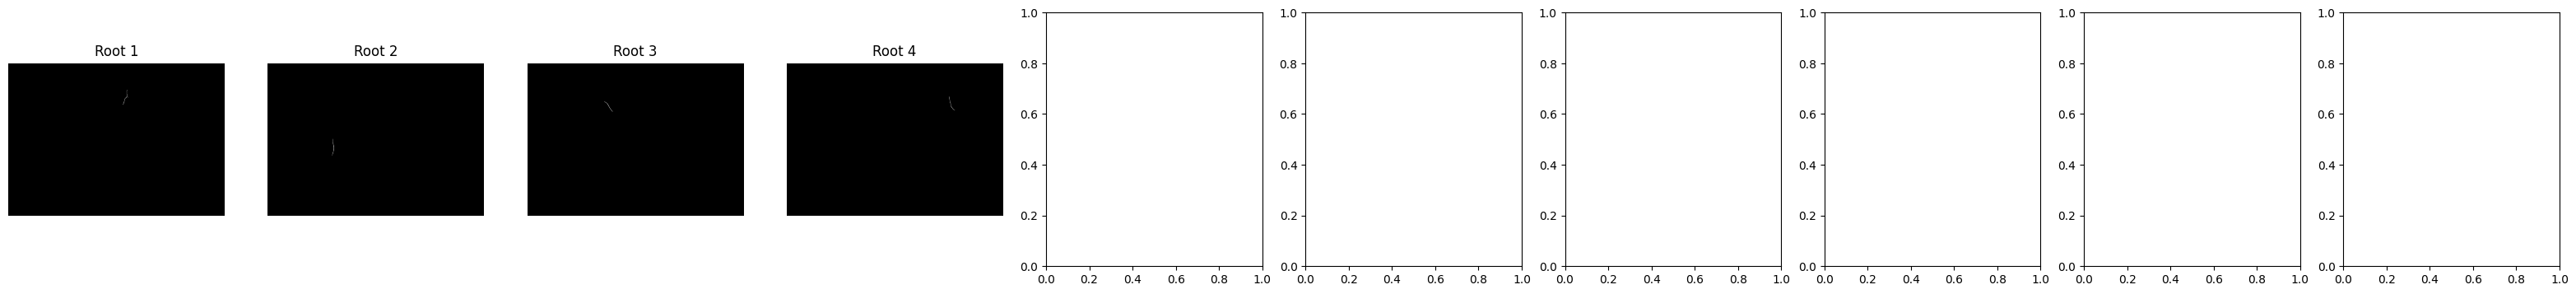

In [4]:
# Task 6 & 7: Individual Root Segmentation & RSA Extraction

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, skeletonize
from skimage.measure import label, regionprops
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx
import os

# --- Paths ---
image_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image.png"
pred_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image_prediction_celine_231265.png"

# --- Load Image and Prediction Mask ---
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

# --- Threshold & Clean Mask ---
_, binary_mask = cv2.threshold(pred_mask, 30, 255, cv2.THRESH_BINARY)
cleaned_mask = remove_small_objects(binary_mask > 0, min_size=1500)  # Increased min_size to reduce noise

# --- Label Individual Roots ---
labeled_mask = label(cleaned_mask)
num_roots = labeled_mask.max()
print(f"Detected {num_roots} root systems")

# --- Visualize All Labeled Roots on Original Image ---
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.imshow(labeled_mask, cmap='nipy_spectral', alpha=0.5)
plt.title("All Detected Root Segments")
plt.axis('off')
plt.show()

# --- Sort Regions by Area and Select Top N ---
regions = regionprops(labeled_mask)
regions = sorted(regions, key=lambda r: r.area, reverse=True)
N = 10  # Change this number to show more/fewer roots

# --- Plot Individual Root Masks ---
fig, axes = plt.subplots(1, N, figsize=(4*N, 4))
if N == 1:
    axes = [axes]
for i in range(N):
    region = regions[i]
    mask = labeled_mask == region.label
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"Root {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# --- Task 7: RSA Extraction ---
def analyze_root(mask, root_id):
    skel = skeletonize(mask)
    g0, c0 = skeleton_to_csgraph(skel)
    skeleton_obj = Skeleton(skel)
    branch_data = summarize(skeleton_obj)
    G = nx.from_pandas_edgelist(branch_data, 'node-id-src', 'node-id-dst', edge_attr='branch-distance')
    coords = np.transpose(c0)

    degree_1_nodes = [n for n in G.nodes if G.degree[n] == 1]
    if len(degree_1_nodes) < 2:
        print(f"Root {root_id}: Not enough endpoints found.")
        return None

    lowest = max(degree_1_nodes, key=lambda n: coords[n][0])
    highest = min(degree_1_nodes, key=lambda n: coords[n][0])

    try:
        path = nx.shortest_path(G, lowest, highest, weight='branch-distance')
        dist = nx.shortest_path_length(G, lowest, highest, weight='branch-distance')
    except nx.NetworkXNoPath:
        print(f"Root {root_id}: No path found.")
        return None

    # --- Visualization ---
    fig, ax = plt.subplots()
    draw.overlay_skeleton_networkx(g0, coords, image=skel, axis=ax, node_size=0)
    ax.scatter(*coords[lowest][::-1], c='green', label='Root Tip')
    ax.scatter(*coords[highest][::-1], c='orange', label='Shoot Base')
    for i in range(len(path)-1):
        y1, x1 = coords[path[i]]
        y2, x2 = coords[path[i+1]]
        ax.plot([x1, x2], [y1, y2], color='red', lw=1.5)
    ax.set_title(f"Root {root_id}: Primary Length = {dist:.2f}px")
    ax.legend()
    plt.show()
    return dist

# --- Analyze Top N Roots ---
lengths = []
for i in range(N):
    region = regions[i]
    mask = labeled_mask == region.label
    length = analyze_root(mask, i+1)
    if length:
        lengths.append((i+1, length))

# --- Print Results ---
print("\nPrimary Root Lengths:")
for root_id, length in lengths:
    print(f"Root {root_id}: {length:.2f} px")